In [8]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.gridspec as gridspec
import ast
import sys
sys.path.append('machine-scientist/')
sys.path.append('machine-scientist/Prior/')
from mcmc import *
from parallel import *
from fit_prior import read_prior_par
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

In [28]:
#Read NN and BMS data
n=8;runid=0;function='tanh' #tanh, leaky_ReLU
realization=0
sigma=0.2
NPAR=10 #10, 20
steps=50000

resolution='1x' #'0.5x', '1x', '2x', '4e-3'
resolutions={'0.5x':'0.1', '1x':'0.05' , '2x': '0.025' , '4e-3x':'0.004' }

#Read NN data
file_model='NN_no_overfit_' + function + '_sigma_' + str(sigma) + '_r_' + str(realization) + '.csv'
model_d='../data/' + resolution + '_resolution/trained_nns/' + file_model


d=pd.read_csv(model_d)
dn=d[d['rep']==n]
dn.set_index('Unnamed: 0', inplace=True)
dn.index.name = None
dn=dn.reset_index(drop=True)
display(dn)

#Read BMS trace
filename='BMS_'+function+'_n_'+str(n)+'_sigma_'+str(sigma)+ '_r_' + str(realization) + '_res_' + resolutions[resolution] + '_trace_'+\
                str(steps)+'_prior_'+str(NPAR)+ '.csv'
trace=pd.read_csv('../data/MSTraces/' + resolution + '_resolution/' + filename, sep=';', header=None, names=['t', 'H', 'expr', 'parvals', 'kk1', 'kk2','kk3'])

,x1,y,rep,noise,y_noise,ymodel
0,-1.95,0.029264,8.0,-0.113262,-0.083998,0.010948
1,-1.90,0.031695,8.0,0.090610,0.122305,0.057318
2,-1.85,0.034179,8.0,0.144487,0.178667,0.054862
3,-1.80,0.036709,8.0,-0.239817,-0.203108,-0.111728
4,-1.75,0.039279,8.0,-0.357154,-0.317875,-0.218677
...,...,...,...,...,...,...
75,1.80,0.983012,8.0,0.253335,1.236348,-1.946725
76,1.85,0.986217,8.0,-0.015826,0.970391,-1.949050
77,1.90,0.989010,8.0,0.020001,1.009011,-1.950872
78,1.95,0.991424,8.0,0.060910,1.052334,-1.952310


In [29]:
#Parameters to read models
VARS = ['x1',]
x = dn[[c for c in VARS]].copy()


if NPAR==10:
    prior_par = read_prior_par('machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np10.2017-10-18 18:07:35.089658.dat')
elif NPAR==20:
    prior_par = read_prior_par('machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np20.maxs200.2024-05-10 162907.551306.dat')

In [25]:
#Minimum description length model
y=dn.y_noise

minrow = trace[trace.H == min(trace.H)].iloc[0]
minH, minexpr, minparvals = minrow.H, minrow.expr, ast.literal_eval(minrow.parvals)

t = Tree(
    variables=list(x.columns),
    parameters=['a%d' % i for i in range(NPAR)],
    x=x, y=y,
    prior_par=prior_par,
    max_size=200,
    from_string=minexpr,
)

t.set_par_values(deepcopy(minparvals))

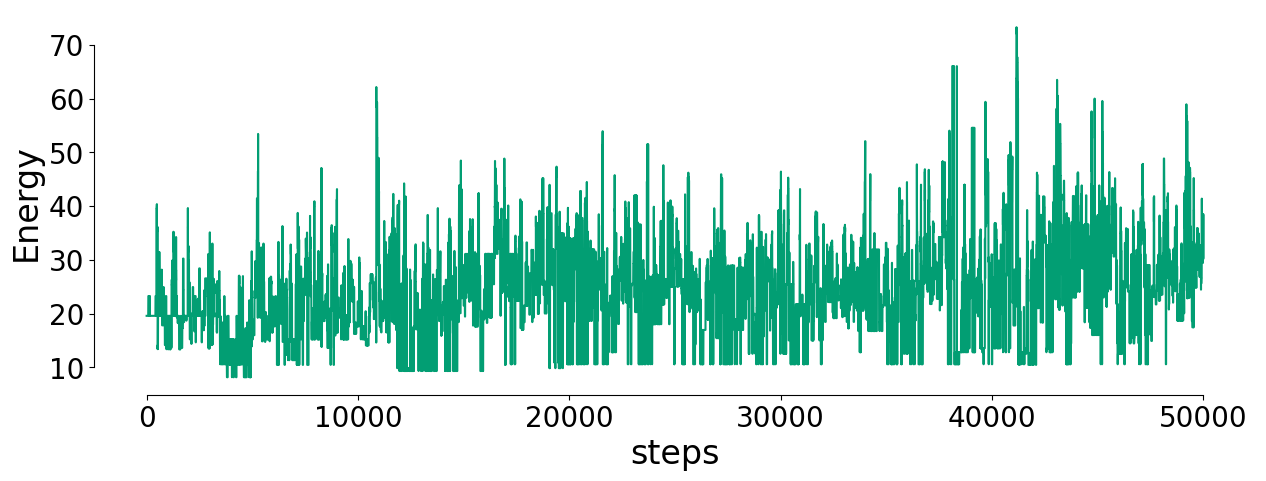

In [26]:
Nini = 00
plt.figure(figsize=(15, 5))


color_data=sns.color_palette("colorblind")[0]
color_noise=sns.color_palette("colorblind")[7]
color_ann=sns.color_palette("colorblind")[4]
color_bms=sns.color_palette("colorblind")[2]

#Define figure size in cm                                                                           
Extensions=['.svg']

#Fonts and sizes                                                                                    
size_axis=7;size_ticks=6;size_title=5
line_w=1;marker_s=3 #width and marker size                                                           
#plt.title(str(function) + ', ' + 'n=' + str(n) +', r=' + str(realization))
plt.plot(trace.t[trace.t > Nini], trace.H[trace.t > Nini], color=color_bms)
plt.xticks(fontsize=20);plt.yticks(fontsize=20)
plt.xlabel('steps',fontsize=24);plt.ylabel('Energy',fontsize=24)
#plt.scatter(minrow['t'], minH,color='r')
sns.despine(trim=True)

Name_figure='Energy_' + function + '_n_' + str(n) + '_sigma_' + str(sigma) + '_r_'  + str(realization) + '_par_' + str(NPAR)

for ext in Extensions:
        plt.savefig('../results/' + Name_figure + ext,dpi=300)

 
plt.show()

80


,x1,y,rep,noise,y_noise,ymodel,ybms
49,0.50,0.499894,8.0,-0.028064,0.471830,0.418876,0.479232
50,0.55,0.543272,8.0,-0.177667,0.365604,0.449341,0.513211
51,0.60,0.584804,8.0,0.264701,0.849505,0.484471,0.546103
52,0.65,0.624083,8.0,-0.549434,0.074649,0.526196,0.577752
53,0.70,0.660852,8.0,-0.035322,0.625529,0.577889,0.608037
54,0.75,0.694977,8.0,-0.053153,0.641824,0.644467,0.636872
55,0.80,0.726426,8.0,-0.027546,0.698880,0.729437,0.664202
56,0.85,0.755236,8.0,0.077378,0.832614,0.823297,0.689999
57,0.90,0.781498,8.0,0.036809,0.818307,0.877209,0.714260
58,0.95,0.805339,8.0,0.175372,0.980711,0.776458,0.736997


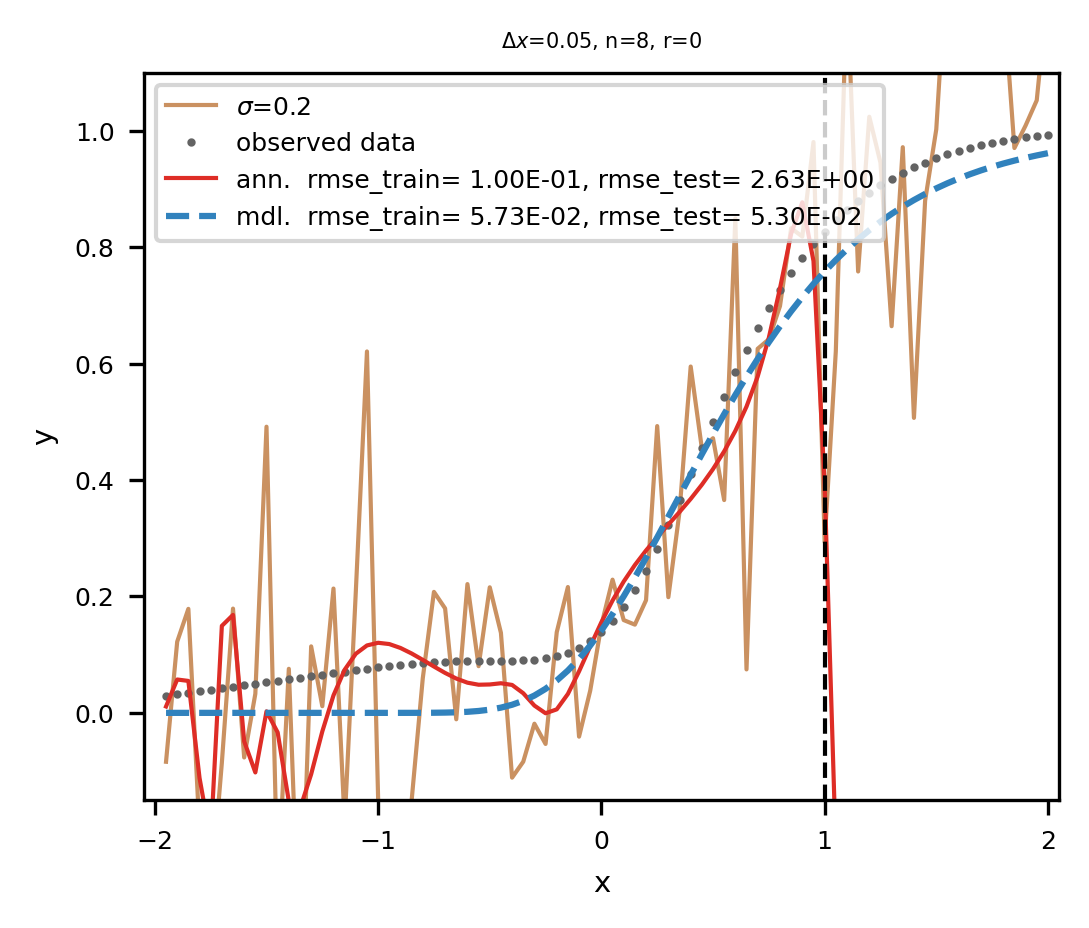

In [30]:
#Plot

#Validation and train borders
n_points=int(len(dn.index))
print(n_points)
train_fraction=5/8;valid_fraction=1/8;test_fraction=0.2
train_size_ann=int(n_points*train_fraction)
train_size_bms=train_size_ann + int(n_points*valid_fraction)


train_border=dn.loc[train_size_bms-1]['x1']

dplot = deepcopy(dn)
dplot['ybms'] = t.predict(x)
display(dplot.loc[train_size_ann-1:])

#ann errors
rmse_nn_train=root_mean_squared_error(dplot.loc[:train_size_bms-1]['ymodel'],dplot.loc[:train_size_bms -1]['y'])
rmse_nn_test=root_mean_squared_error(dplot.loc[train_size_bms-1:]['ymodel'],dplot.loc[train_size_bms -1:]['y'])
#rmse_nn_validation=root_mean_squared_error(dplot.iloc[validation_points]['ymodel'],dplot.iloc[validation_points]['y'])

#bms errors
rmse_mdl=root_mean_squared_error(dplot.ybms,dn.y)
rmse_mdl_train=root_mean_squared_error(dplot.loc[:train_size_bms-1]['ybms'],dn.loc[:train_size_bms-1]['y'])
rmse_mdl_test =root_mean_squared_error(dplot.loc[train_size_bms-1:]['ybms'],dn.loc[train_size_bms-1:]['y'])

 
#Define figure size in cm                                                                           
cm = 1/2.54 #convert inch to cm                                                                     
width = 10*cm; height=8*cm

Extensions=['.png']

#Fonts and sizes                                                                                    
size_axis=7;size_ticks=6;size_title=5
line_w=1;marker_s=3 #width and marker size                                                          


fig=figure(figsize=(width,height), dpi=300)           

#colors from seaborn's colorblind palette
#--------------------------------------------------
#color_data=sns.color_palette("colorblind")[0]
#color_noise=sns.color_palette("colorblind")[7]
#color_ann=sns.color_palette("colorblind")[4]
#color_bms=sns.color_palette("colorblind")[2]
#color_valid_ann=sns.color_palette("colorblind")[8]
#--------------------------------------------------

#Colors
#----------------------------------------------
colors_june={'0.5x':['#fee0d2', '#deebf7'],
       '1x':['#fc9272', '#9ecae1'],
       '2x':['#de2d26', '#3182bd'] }

color_noise=sns.color_palette("colorblind")[5]
color_data='#636363'
color_bms=colors_june['2x'][1]
color_ann=colors_june['2x'][0]
#-----------------------------------------------


plt.plot(dn['x1'], dn['y_noise'],linewidth=line_w, markersize=2, color=color_noise,label=r'$\sigma$=' + str(sigma) )
plt.plot(dn['x1'], dn['y'],'.', markersize=2, color=color_data,label='observed data') 
plt.plot(dn['x1'], dn['ymodel'],linewidth=line_w, color=color_ann, label='ann.  rmse_train= %.2E, rmse_test= %.2E' % ( rmse_nn_train, rmse_nn_test))
plt.plot(dplot.x1, dplot.ybms, color=color_bms, linestyle='--',label='mdl.  rmse_train= %.2E, rmse_test= %.2E' % ( rmse_mdl_train, rmse_mdl_test)) 
                                                                                

plt.axvline(x=train_border,linestyle='--',linewidth=line_w, color='k')

#plt.title('$%s$' % t.latex(),fontsize=size_title)
plt.title(r'$\Delta x$=%s, n=%d, r=%d' % (resolutions[resolution], n, realization),fontsize=size_title)
plt.xlabel('x',fontsize=size_axis);plt.ylabel('y',fontsize=size_axis)
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.legend(loc='best', fontsize=size_ticks)

plt.xlim(-2.05,2.05);plt.ylim(-0.15,1.1)  

if test==False:
    Name_figure='Prediction_' + resolution + '_' + function + '_n_' + str(n) + '_sigma_' + str(sigma) + '_r_'  + str(realization) + '_par_' + str(NPAR)
elif test==True:
     Name_figure='Prediction_test' + resolution + '_' + function + '_n_' + str(n) + '_sigma_' + str(sigma) + '_r_'  + str(realization) + '_par_' + str(NPAR)

    
for ext in Extensions:
        plt.savefig('../results/' + Name_figure +ext,dpi=300)

plt.show()